# Calibration of climate parameters

In [ ]:
%cd ..

In [2]:
import yaml
import numpy as np
import pandas as pd
from mce.core import ScenarioBase
from mce.core.calib import CalibBase
from mce.core.driver import DriverBase
from mce.util.plot_base import PlotBase

In [3]:
myplt = PlotBase(palette='ipcc_wg1')

In [4]:
# Definitions of MCE variables and parameters
with open('mce/core/attributes.yml') as f1:
    mce_attrs = yaml.safe_load(f1)

In [ ]:
# Normalized CMIP data, created in calib_climate_pre.ipynb
ds = ScenarioBase(outpath='data/calib_cmip.h5', mode='a')

## Drivers for calibration runs

In [6]:
class Driver4x(DriverBase):
    """Driver for abrupt-4xCO2 using a simple response function
    instead of generic time integration in the base class
    """
    def run(self, time):
        climate = self.climate
        forcing = self.forcing

        f4x = forcing.x2erf(4)
        resp = climate.response_ideal(time, variable='flux')

        return pd.DataFrame({
            'rtnt': resp * f4x,
            'tas': (1 - resp) * f4x / climate.parms.lamb,
        }, index=time)

class Driver1p(DriverBase):
    """Driver for 1pctCO2 using a climate-only response function
    instead of generic time integration in the base class
    """
    def run(self, time):
        climate = self.climate
        forcing = self.forcing

        f1p = self.forcing.xl2erf(time * np.log(1.01))
        resp = climate.response(time, f1p)

        return pd.DataFrame({
            'rtnt': f1p - climate.parms.lamb * resp,
            'tas': resp,
        }, index=time)

### Test runs using default parameters

In [7]:
config = {'climate': {'nl': 3}} # three-layer (default)

# abrupt-4xCO2 for 150 years including initial zero
drv = Driver4x(**config)
time = np.hstack([0., np.arange(150) + 0.5])
df_4x = drv.run(time)

# 1pctCO2 for 140 years including initial zero
drv = Driver1p(**config)
time = np.hstack([0., np.arange(140) + 0.5])
df_1p = drv.run(time)

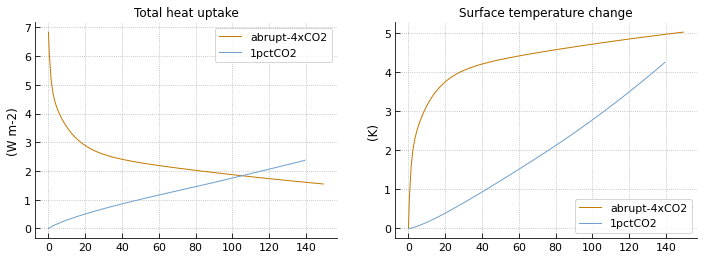

In [8]:
myplt.init_regular(2, col=2)

map_color = {'1pctCO2': 'C1', 'abrupt-4xCO2': 'C2'}
variable_order = ['rtnt', 'tas']
scenario_order = ['abrupt-4xCO2', '1pctCO2']

for ax, var_id in zip(myplt(), variable_order):
    for scenario, df in zip(scenario_order, [df_4x, df_1p]):
        color = map_color[scenario]
        d1 = df[var_id]
        ax.plot(d1.index, d1, color=color, label=scenario)

    ax.legend()
    attrs = mce_attrs['variables'][var_id]
    ax.set_ylabel('({})'.format(attrs['units']))
    ax.set_title(attrs['long_name'])
    ax.grid()

## Calibration

In [9]:
class CalibClimate(CalibBase):
    def __init__(self, *Drivers, **kw_all):
        super().__init__(*Drivers, **kw_all)

        # Define minimum values for several control parameters
        self.value_min = {
            'af0': 0.01,
            'af1': 0.01,
            'tau0': 0.,
            't1': 2.,
            't2': 2.,
        }

    def retrieve_model_parms(self, kw_all, **parms):
        """Retrieve model parameters from optimized control parameters
        """
        kw_irm = kw_all['kw_irm']
        p = parms['irm']
        b = np.array([p['af0'], p['af1']])
        kw_irm['asj'][0] = 1./(1.+b.sum())
        kw_irm['asj'][1:] = kw_irm['asj'][0] * b
        kw_irm['tauj'][0] = p['tau0']
        kw_irm['tauj'][1] = p['t1'] * kw_irm['tauj'][0]
        kw_irm['tauj'][2] = p['t2'] * kw_irm['tauj'][1]
        kw_irm['lamb'] = p['lamb']

        kw_rfall = kw_all['kw_rfall']
        p = parms['rf']
        kw_rfall['beta'] = p['beta']
        kw_rfall['alpha'] = p['ts4xeq'] * kw_irm['lamb'] / kw_rfall['beta'] / np.log(4)

    def get_model_config(self):
        """Returns model configurations given to Drivers
        """
        config = {'climate': {'nl': 3}}
        return [config] * 2

    def get_run_args(self):
        """Returns tuples given to Driver.run() including time points
        """
        experiment_order = self.data[2]
        dim_sizes = [140 if exp1 == '1pctCO2' else 150 for exp1 in experiment_order]
        return [
            ((np.hstack([0., np.arange(n) + 0.5]),), {}) # zero time point added
            for n in dim_sizes
        ]

    def get_diff(self, results):
        """Define residual series to be minimized

        Parameters
        ----------
        results
            List of output from Driver.run()
        """
        data, data_std = self.data[:2]
        experiment_order = self.data[2]
        variable_order = self.data[3]

        xdiff = []
        for exp1, df in zip(experiment_order, results):
            for vn in variable_order:
                xdiff.append(
                    data[exp1][vn].values - df[vn].iloc[1:].values
                )
                xdiff[-1] /= data_std[vn]

        return np.hstack(xdiff)

In [10]:
# Retrieve default parameters as reference
drv = DriverBase()
kw_all_ref = {
    'kw_irm': drv.climate.parms(),
    'kw_rfall': drv.forcing.parms(),
}
del kw_all_ref['kw_rfall']['ccref'] # no need for this parameter
kw_all_ref

{'kw_irm': {'asj': array([0.2616, 0.3362, 0.4022]),
  'tauj': array([  1.033,  10.48 , 260.6  ]),
  'lamb': 1.053},
 'kw_rfall': {'alpha': 4.617, 'beta': 1.068}}

In [11]:
calib = CalibClimate(Driver4x, Driver1p, **kw_all_ref)

In [12]:
norm_type = 'norm1'
variable_order = ['rtnt', 'tas']
# initial values of control parameters 
px_ini = {
    'irm': {
        'af0': 1., # asj[1] / asj[0]
        'af1': 1., # asj[2] / asj[0]
        'tau0': 1.,
        't1': 10., # tauj[1] / tauj[0]
        't2': 20., # tauj[2] / tauj[1]
        'lamb': 1.,
    },
    'rf': {'ts4xeq': 7., 'beta': 1.},
}
results = {}

for cmip_era in ['CMIP5', 'CMIP6']:
    if cmip_era == 'CMIP5':
        experiment_order = ['abrupt4xCO2', '1pctCO2']
    else:
        experiment_order = ['abrupt-4xCO2', '1pctCO2']

    for source_id, grp in ds.file[f'calib/{cmip_era}'].items():
        if len(grp) < 3:
            print('skip', cmip_era, source_id)
            continue

        print(cmip_era, source_id)

        data = {}
        for exp1 in experiment_order:
            data[exp1] = pd.DataFrame({
                vn: grp[f'{exp1}/{norm_type}/{vn}']
                for vn in variable_order
            })

        exp1 = 'piControl'
        data_std = {
            vn: np.std(grp[f'{exp1}/{norm_type}/{vn}'])
            for vn in variable_order
        }

        kw_all = calib.minimize_wrap(
            data, data_std,
            experiment_order, variable_order,
            **px_ini,
        )
        # calib.ret.params
        results[(cmip_era, source_id)] = kw_all

CMIP5 ACCESS1.0
CMIP5 ACCESS1.3
CMIP5 BCC-CSM1.1
CMIP5 BNU-ESM
CMIP5 CCSM4
CMIP5 CNRM-CM5
CMIP5 CSIRO-Mk3.6.0
CMIP5 CanESM2
CMIP5 FGOALS-s2
CMIP5 GFDL-CM3
CMIP5 GFDL-ESM2G
CMIP5 GFDL-ESM2M
CMIP5 GISS-E2-H
CMIP5 GISS-E2-R
CMIP5 HadGEM2-ES
CMIP5 INM-CM4
CMIP5 IPSL-CM5A-LR
CMIP5 IPSL-CM5B-LR
CMIP5 MIROC-ESM
CMIP5 MIROC5
CMIP5 MPI-ESM-LR
CMIP5 MPI-ESM-MR
CMIP5 MPI-ESM-P
CMIP5 MRI-CGCM3
CMIP5 NorESM1-M
CMIP6 ACCESS-CM2
CMIP6 ACCESS-ESM1-5
CMIP6 AWI-CM-1-1-MR
CMIP6 BCC-CSM2-MR
CMIP6 BCC-ESM1
CMIP6 CAMS-CSM1-0
skip CMIP6 CAS-ESM2-0
CMIP6 CESM2
CMIP6 CESM2-FV2
CMIP6 CESM2-WACCM
CMIP6 CESM2-WACCM-FV2
CMIP6 CIESM
CMIP6 CMCC-CM2-SR5
CMIP6 CNRM-CM6-1
CMIP6 CNRM-CM6-1-HR
CMIP6 CNRM-ESM2-1
CMIP6 CanESM5
CMIP6 E3SM-1-0
CMIP6 EC-Earth3
CMIP6 EC-Earth3-Veg
CMIP6 FGOALS-f3-L
CMIP6 FGOALS-g3
CMIP6 GFDL-CM4
CMIP6 GFDL-ESM4
CMIP6 GISS-E2-1-G
CMIP6 GISS-E2-1-H
CMIP6 GISS-E2-2-G
CMIP6 HadGEM3-GC31-LL
CMIP6 HadGEM3-GC31-MM
CMIP6 IITM-ESM
CMIP6 INM-CM4-8
skip CMIP6 INM-CM5-0
CMIP6 IPSL-CM6A-LR
CMIP6 MIROC-ES2L

CMIP5 ACCESS1.3
CMIP5 BCC-CSM1.1
CMIP5 BNU-ESM
CMIP5 CCSM4
CMIP5 CNRM-CM5
CMIP5 CSIRO-Mk3.6.0
CMIP5 CanESM2
CMIP5 FGOALS-s2
CMIP5 GFDL-CM3
CMIP5 GFDL-ESM2G
CMIP5 GFDL-ESM2M
CMIP5 GISS-E2-H
CMIP5 GISS-E2-R
CMIP5 HadGEM2-ES
CMIP5 INM-CM4
CMIP5 IPSL-CM5A-LR
CMIP5 IPSL-CM5B-LR
CMIP5 MIROC-ESM
CMIP5 MIROC5
CMIP5 MPI-ESM-LR
CMIP5 MPI-ESM-MR
CMIP5 MPI-ESM-P
CMIP5 MRI-CGCM3
CMIP5 NorESM1-M
CMIP6 ACCESS-CM2
CMIP6 ACCESS-ESM1-5
CMIP6 AWI-CM-1-1-MR
CMIP6 BCC-CSM2-MR
CMIP6 BCC-ESM1
CMIP6 CAMS-CSM1-0
skip CMIP6 CAS-ESM2-0
CMIP6 CESM2
CMIP6 CESM2-FV2
CMIP6 CESM2-WACCM
CMIP6 CESM2-WACCM-FV2
CMIP6 CIESM
CMIP6 CMCC-CM2-SR5
CMIP6 CNRM-CM6-1
CMIP6 CNRM-CM6-1-HR
CMIP6 CNRM-ESM2-1
CMIP6 CanESM5
CMIP6 E3SM-1-0
CMIP6 EC-Earth3
CMIP6 EC-Earth3-Veg
CMIP6 FGOALS-f3-L
CMIP6 FGOALS-g3
CMIP6 GFDL-CM4
CMIP6 GFDL-ESM4
CMIP6 GISS-E2-1-G
CMIP6 GISS-E2-1-H
CMIP6 GISS-E2-2-G
CMIP6 HadGEM3-GC31-LL
CMIP6 HadGEM3-GC31-MM
CMIP6 IITM-ESM
CMIP6 INM-CM4-8
skip CMIP6 INM-CM5-0
CMIP6 IPSL-CM6A-LR
CMIP6 MIROC-ES2L
CMIP6 MIROC6
CM

In [16]:
# Save results
kfmt = 'parms/{}/{}/l3_norm1/{}'.format

for (cmip_era, source_id), kw_all in results.items():
    for kw_comp, parms in kw_all.items():
        grp = ds.file.create_group(kfmt(cmip_era, source_id, kw_comp))
        for k, v in parms.items():
            grp.attrs[k] = v

In [26]:
# An example of calibration results
cmip_era = 'CMIP6'
source_id = 'MIROC-ES2L'

config = {'climate': {'nl': 3}}
kw_all = {
    k: dict(v.attrs) for k, v in
    ds.file[f'parms/{cmip_era}/{source_id}/l3_norm1'].items()
}

In [27]:
kw_all

{'kw_irm': {'asj': array([0.30797088, 0.38143276, 0.31059636]),
  'lamb': 1.4391290582698961,
  'tauj': array([  0.97030757,   9.81658393, 574.12900701])},
 'kw_rfall': {'alpha': 5.07538912760419, 'beta': 1.1151588900196678}}

In [ ]:
drv = Driver4x(**{**config, **kw_all})
time = np.hstack([0, np.arange(150) + 0.5])
df_4x = drv.run(time)

drv = Driver1p(**{**config, **kw_all})
df_1p = drv.run(time[:141])

In [18]:
df_4x_esm = pd.DataFrame({
    k: v for k, v in
    ds.file[f'calib/{cmip_era}/{source_id}/abrupt-4xCO2/norm1'].items()
}).set_index('time')

df_1p_esm = pd.DataFrame({
    k: v for k, v in
    ds.file[f'calib/{cmip_era}/{source_id}/1pctCO2/norm1'].items()
}).set_index('time')

In [22]:
for df in [df_4x_esm, df_1p_esm]:
    df.index = df.index.values - df.index[0] + 0.5

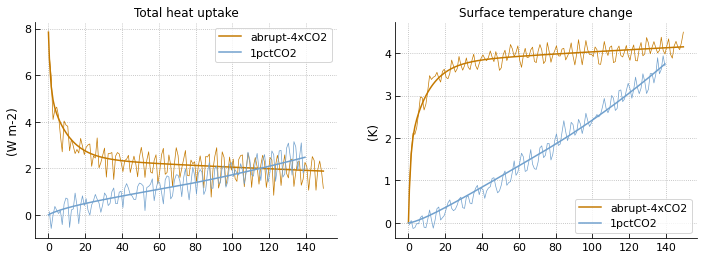

In [23]:
myplt.init_regular(2, col=2)

map_color = {'1pctCO2': 'C1', 'abrupt-4xCO2': 'C2'}
variable_order = ['rtnt', 'tas']
scenario_order = ['abrupt-4xCO2', '1pctCO2']

for ax, var_id in zip(myplt(), variable_order):
    for scenario, df_esm, df in zip(scenario_order, [df_4x_esm, df_1p_esm], [df_4x, df_1p]):
        color = map_color[scenario]
        d1 = df_esm[var_id]
        ax.plot(d1.index, d1, color=color, lw=0.7)
        d1 = df[var_id]
        ax.plot(d1.index, d1, color=color, lw=1.5, label=scenario)

    ax.legend()
    attrs = mce_attrs['variables'][var_id]
    ax.set_ylabel('({})'.format(attrs['units']))
    ax.set_title(attrs['long_name'])
    ax.grid()

## Import existing calibration results

In [3]:
ds = ScenarioBase(outpath='data/calib_cmip.h5', mode='a')

[2025-05-02 08:24:34 mce.core] INFO:data/calib_cmip.h5 already exists
[2025-05-02 08:24:34 mce.core] INFO:file data/calib_cmip.h5 opened with mode=a


In [43]:
# https://github.com/tsutsui1872/ar6-tlm
df = pd.read_csv('../ar6-tlm/dataout/parms_calib.csv', index_col=[0, 1])
df

q4x      lamg       cdeep      cmix  gamma_2l  \
Method Dataset                                                             
ar6    ACCESS-CM2     7.733057  0.699488   93.230040  8.705751  0.542905   
       ACCESS-ESM1-5  6.745166  0.712660   95.361976  8.381012  0.619427   
       AWI-CM-1-1-MR  8.168461  1.209335   56.493956  8.200244  0.475052   
       BCC-CSM2-MR    7.217011  1.143931   64.573536  5.936500  0.872355   
       BCC-ESM1       6.488241  0.892194   97.662585  8.695826  0.529933   
...                        ...       ...         ...       ...       ...   
mce-2l NorESM2-LM     6.615321  1.276142  117.625608  3.434206  0.871714   
       NorESM2-MM     7.072782  1.389735  112.052479  3.815150  0.825756   
       SAM0-UNICON    7.255909  0.943384  109.087494  5.775929  0.749171   
       TaiESM1        7.272367  0.811419   87.053832  7.131655  0.689128   
       UKESM1-0-LL    7.299849  0.687853   65.661704  7.527359  0.632484   

                           eff      tau0        tau1        a0        a1  \
Method Dataset                                                             
ar6    ACCESS-CM2     1.496768  5.653977  378.010245  0.445999  0.554001   
       ACCESS-ESM1-5  1.604319  4.820713  375.567394  0.402246  0.597754   
       AWI-CM-1-1-MR  1.448388  4.264331  189.099361  0.620322  0.379678   
       BCC-CSM2-MR    1.303708  2.556726  150.247677  0.483884  0.516116   
       BCC-ESM1       1.368489  5.305895  338.532502  0.537132  0.462868   
...                        ...       ...         ...       ...       ...   
mce-2l NorESM2-LM          NaN  1.591194  228.208766  0.588413  0.411587   
       NorESM2-MM          NaN  1.713863  217.356912  0.621318  0.378682   
       SAM0-UNICON         NaN  3.377058  263.990592  0.545765  0.454235   
       TaiESM1             NaN  4.670360  237.729205  0.521989  0.478011   
       UKESM1-0-LL         NaN  5.550883  204.666957  0.493505  0.506495   

                           q2x  co2_beta       ecs       tcr  
Method Dataset                                                
ar6    ACCESS-CM2     3.680935       NaN  5.262326  2.409353  
       ACCESS-ESM1-5  3.210699       NaN  4.505233  1.921801  
       AWI-CM-1-1-MR  3.888188       NaN  3.215145  2.071938  
       BCC-CSM2-MR    3.435297       NaN  3.003064  1.709459  
       BCC-ESM1       3.088403       NaN  3.461580  1.871806  
...                        ...       ...       ...       ...  
mce-2l NorESM2-LM     2.808846  1.177587  2.201046  1.390751  
       NorESM2-MM     2.924660  1.209163  2.104474  1.390466  
       SAM0-UNICON    3.608986  1.005256  3.825574  2.197015  
       TaiESM1        3.645495  0.997446  4.492738  2.473972  
       UKESM1-0-LL    3.658670  0.997610  5.318972  2.826370  

[122 rows x 14 columns]

In [44]:
# AR6 two-layer model uses its own scheme for CO2 forcing
# Here, co2_alpha is derived from q4x with an assumed fixed factor of q2x to q4x (0.476)
# and co2_beta is filled with 0.5/0.476 for consistency
df['co2_alpha'] = df['q2x'] / np.log(2)
df.fillna({'co2_beta': 0.5/0.476}, inplace=True)

In [54]:
# For MCE two-layer, ocean heat uptake efficacy is set to 1
df.fillna({'eff': 1.}, inplace=True)

In [55]:
df

q4x      lamg       cdeep      cmix  gamma_2l  \
Method Dataset                                                             
ar6    ACCESS-CM2     7.733057  0.699488   93.230040  8.705751  0.542905   
       ACCESS-ESM1-5  6.745166  0.712660   95.361976  8.381012  0.619427   
       AWI-CM-1-1-MR  8.168461  1.209335   56.493956  8.200244  0.475052   
       BCC-CSM2-MR    7.217011  1.143931   64.573536  5.936500  0.872355   
       BCC-ESM1       6.488241  0.892194   97.662585  8.695826  0.529933   
...                        ...       ...         ...       ...       ...   
mce-2l NorESM2-LM     6.615321  1.276142  117.625608  3.434206  0.871714   
       NorESM2-MM     7.072782  1.389735  112.052479  3.815150  0.825756   
       SAM0-UNICON    7.255909  0.943384  109.087494  5.775929  0.749171   
       TaiESM1        7.272367  0.811419   87.053832  7.131655  0.689128   
       UKESM1-0-LL    7.299849  0.687853   65.661704  7.527359  0.632484   

                           eff      tau0        tau1        a0        a1  \
Method Dataset                                                             
ar6    ACCESS-CM2     1.496768  5.653977  378.010245  0.445999  0.554001   
       ACCESS-ESM1-5  1.604319  4.820713  375.567394  0.402246  0.597754   
       AWI-CM-1-1-MR  1.448388  4.264331  189.099361  0.620322  0.379678   
       BCC-CSM2-MR    1.303708  2.556726  150.247677  0.483884  0.516116   
       BCC-ESM1       1.368489  5.305895  338.532502  0.537132  0.462868   
...                        ...       ...         ...       ...       ...   
mce-2l NorESM2-LM     1.000000  1.591194  228.208766  0.588413  0.411587   
       NorESM2-MM     1.000000  1.713863  217.356912  0.621318  0.378682   
       SAM0-UNICON    1.000000  3.377058  263.990592  0.545765  0.454235   
       TaiESM1        1.000000  4.670360  237.729205  0.521989  0.478011   
       UKESM1-0-LL    1.000000  5.550883  204.666957  0.493505  0.506495   

                           q2x  co2_beta       ecs       tcr  co2_alpha  
Method Dataset                                                           
ar6    ACCESS-CM2     3.680935  1.050420  5.262326  2.409353   5.310467  
       ACCESS-ESM1-5  3.210699  1.050420  4.505233  1.921801   4.632059  
       AWI-CM-1-1-MR  3.888188  1.050420  3.215145  2.071938   5.609469  
       BCC-CSM2-MR    3.435297  1.050420  3.003064  1.709459   4.956086  
       BCC-ESM1       3.088403  1.050420  3.461580  1.871806   4.455623  
...                        ...       ...       ...       ...        ...  
mce-2l NorESM2-LM     2.808846  1.177587  2.201046  1.390751   4.052309  
       NorESM2-MM     2.924660  1.209163  2.104474  1.390466   4.219392  
       SAM0-UNICON    3.608986  1.005256  3.825574  2.197015   5.206666  
       TaiESM1        3.645495  0.997446  4.492738  2.473972   5.259338  
       UKESM1-0-LL    3.658670  0.997610  5.318972  2.826370   5.278345  

[122 rows x 15 columns]

In [59]:
map_label = {
    'ar6': 'l2e_ar6', # AR6 WGI Chapter 7
    's21': 'l2e_s21', # Smith et al., 2021, https://doi.org/10.1029/2020JD033622
    'mce-2l': 'l2_norm1', # MCE 2-layer to the same normalized data
}
for (method, source_id), p in df.iterrows():
    kw_all = {
        'kw_irm': {
            'asj': p[['a0', 'a1']].values,
            'tauj': p[['tau0', 'tau1']].values,
            'lamb': p['lamg'],
            'eff': p['eff'],
        },
        'kw_rfall': {
            'alpha': p['co2_alpha'],
            'beta': p['co2_beta'],
        },
    }
    gn = 'parms/CMIP6/{}/{}'.format(source_id, map_label[method])
    for comp, parms in kw_all.items():
        grp = ds.file.create_group(f'{gn}/{comp}')
        for k, v in parms.items():
            grp.attrs[k] = v

In [75]:
import pprint

In [77]:
# Look up different parameters calibrated to a specific model
pprint.pprint({
    k: {comp: dict(parms.attrs) for comp, parms in v.items()}
    for k, v in ds.file['parms/CMIP6/IPSL-CM6A-LR'].items()
})

{'l2_norm1': {'kw_irm': {'asj': array([0.55013424, 0.44986576]),
                         'eff': 1.0,
                         'lamb': 0.7584610878257885,
                         'tauj': array([  5.61093215, 162.76938357])},
              'kw_rfall': {'alpha': 4.2276625612767855,
                           'beta': 1.1732679231854382}},
 'l2e_ar6': {'kw_irm': {'asj': array([0.51558682, 0.48441318]),
                        'eff': 1.5756369839666575,
                        'lamb': 0.6910367205687997,
                        'tauj': array([  6.0381827 , 464.56715915])},
             'kw_rfall': {'alpha': 5.364754061408322,
                          'beta': 1.050420168067227}},
 'l2e_s21': {'kw_irm': {'asj': array([0.5407912, 0.4592088]),
                        'eff': 1.3501,
                        'lamb': 0.7635,
                        'tauj': array([  5.93271874, 247.58106832])},
             'kw_rfall': {'alpha': 5.1658038875775745,
                          'beta': 1.0504201680672

In [78]:
ds.close()

[2025-05-02 10:20:43 mce.core] INFO:file data/calib_cmip.h5 closed
